In [ ]:

!unzip /content/drive/MyDrive/fashion-mnist.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: fashion-mnist/test/0/2423.png  
  inflating: fashion-mnist/test/0/444.png  
  inflating: fashion-mnist/test/0/965.png  
  inflating: fashion-mnist/test/0/1460.png  
  inflating: fashion-mnist/test/0/3440.png  
  inflating: fashion-mnist/test/0/2795.png  
  inflating: fashion-mnist/test/0/2474.png  
  inflating: fashion-mnist/test/0/169.png  
  inflating: fashion-mnist/test/0/1647.png  
  inflating: fashion-mnist/test/0/2121.png  
  inflating: fashion-mnist/test/0/2163.png  
  inflating: fashion-mnist/test/0/2753.png  
  inflating: fashion-mnist/test/0/645.png  
  inflating: fashion-mnist/test/0/34.png  
  inflating: fashion-mnist/test/0/716.png  
  inflating: fashion-mnist/test/0/3874.png  
  inflating: fashion-mnist/test/0/3128.png  
  inflating: fashion-mnist/test/0/2180.png  
  inflating: fashion-mnist/test/0/2439.png  
  inflating: fashion-mnist/test/0/269.png  
  inflating: fashion-mnist/test/0/2027.pn

In [1]:
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')

test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)

np.random.shuffle(test_files)

len(train_files), len(test_files)

(55000, 5000)

In [2]:
train_files=train_files[:(int (len(train_files)*0.1))]

test_files=test_files[:(int (len(test_files)*0.1))]

len(train_files), len(test_files)

(5500, 500)

In [4]:
import torch

model = torch.hub.load('pytorch/vision', 'alexnet', pretrained=True)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de ResNet 224x224 px
data_transform = transforms.Compose([
                 transforms.Resize((224, 224)),
                 transforms.Grayscale(3), 
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

In [6]:
2
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append( np.array(data_transform(Image.open(train_file) )))

In [7]:

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(data_transform(Image.open(test_file)) ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


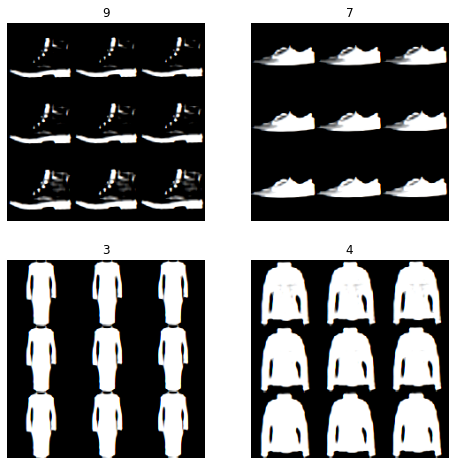

In [8]:

#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15].reshape(224,224,3))
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [9]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([5500, 3, 224, 224])

In [14]:
  #-- Creamos el DataLoader

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [10]:
#--- Congelamos los pesos en las capaz del modelo para que no se actualicen
for p in model.parameters():
    p.requires_grad = False

#--- Definimos el número de clases
out_dim = 10

#--- Reescribimos la nueva capa de salida con el nuevo dataset
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=9216, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=4096, out_features=10, bias=True)

)


model.load_state_dict(model.state_dict())

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:

!pip install hiddenlayer

In [12]:

import hiddenlayer as hl


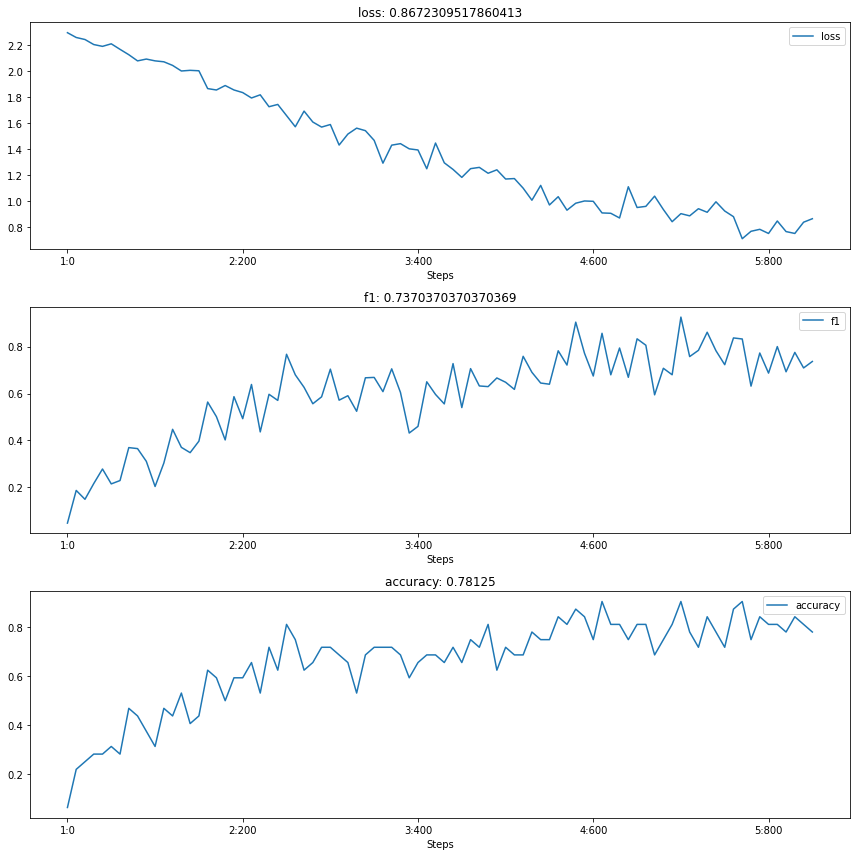

In [15]:
#--- Creamos variables para almacenar los scores en cada época 
from sklearn.metrics import f1_score
model = model.cuda()

model.train()

#--- Definimos nuestro criterio de evaluación y el optimizador 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.1)
criterion = torch.nn.CrossEntropyLoss()


#--- Entrenamos el modelo usando únicamente 5 épocas
n_epochs = 5

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epochs):
  for batch_idx, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    # Pasamos os datos a 'cuda'
    
    X_train_batch = X_train_batch.cuda()
    Y_train_batch = Y_train_batch.cuda()

    # Realiza una predicción
    Y_pred = model(X_train_batch)

    # Calcula el loss
    loss = criterion(Y_pred, Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    # Calcula el accuracy
    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter),f1=f1, loss=loss, accuracy=acc)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["f1"])
          canvas.draw_plot(history["accuracy"])

    iter += 1
    del X_train_batch, Y_train_batch, Y_pred

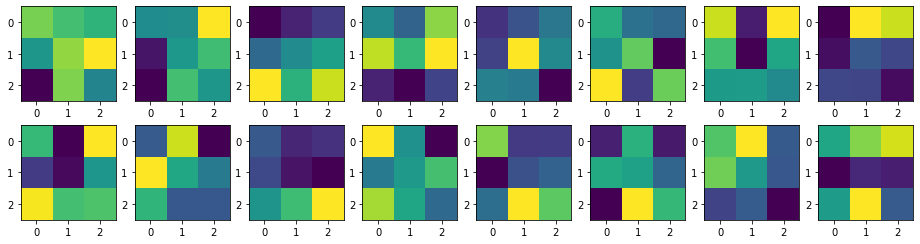

In [17]:
#-- Visualizando los mapas de características de la ultima  capa convolucional y se miran las primeras 16 caracteristicas ya que aqui hay 256

kernels = list(model.children())[0][8].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0

for i in range(kernels.size(0)):
  if(k>=16):
    break
  plt.subplot(2,8,k+1)
  plt.imshow(kernels[i][0].cpu().squeeze())
  k += 1
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

In [19]:

#--- Guardamos el nuevo Modelo
torch.save(model,open('./AlexNet_MNIST.pt','wb'))

In [20]:
X_test, Y_test = X_test.cuda(), Y_test.cuda()
model=model.cuda()
model.eval()
Xvl = X_test
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

Loss:0.68, F1:0.79, Acc:0.80


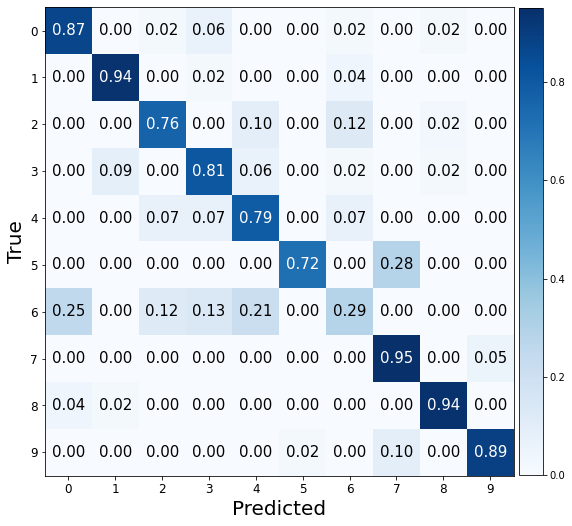

In [21]:
CM(Y_test.cpu(), Y_pred.cpu(), 10)

## Primero : Elegi el modelo **Alexnet** preentrenado por 2 razones: De los 3 modelos, no quize usar el que utilizamos en clase y porque en la descripcion nos dice que es diseñado para imagenet.

##En **alexnet** hay 3 conjutos grandes de capas. Donde la primera sequantial tiene 13 capas( Con 5 capas convolucional cada una con su Relu y MaxPool ), la segunda avgpool tiene 1 capa y classifier (la tercera ) tiene 7 capas. El numero de caracterisitcas va variando a medida de cada capa pero la ultima tiene 256 caracteristicas. Este modelo es optimo porque no tiene un gran numero de capas para mi computador. Tambien, se puede ver los valores de Loss:0.68, F1:0.79, Acc:0.80 que son buenos si consideramos que apenas llegamos a la 5 epoca. y a tabla de confusion que podemos observar que la clase 6 es la que tiene una mayor confusion.

## Advertencia: SOlo se tomo el 10% de los datos del train para que no se crasheará.

